In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
sr = 1000
f1 = 17
t1 = np.arange(0,2000)
phi_1 = np.hstack((np.ones(50), 2*np.ones(50)))
phase_1 = np.ones((100,len(t1)), dtype=int)
for i in range(len(phase_1)):
    phase_1[i] = np.linspace(-i/3,i/3,len(t1))
    # phase_1[i] = np.linspace(i/3,i/3,len(t1))

f2 = 30
t2 = np.arange(0,2000)
phi_2 = np.hstack((2*np.ones(50), np.ones(50)))
phase_2 = np.ones((100,len(t1)), dtype=int)
for i in range(len(phase_2)):
    phase_2[i,:int(.5*len(t1))] = np.linspace(i/3,-i/3,int(.5*len(t1)))
    phase_2[i,int(.5*len(t1)):] = np.linspace(i/2,-i/2,int(.5*len(t1)))
    # phase_2[i,:int(.5*len(t1))] = np.linspace(i/3,i/3,int(.5*len(t1)))
    # phase_2[i,int(.5*len(t1)):] = np.linspace(i/2,i/2,int(.5*len(t1)))

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                   phi_1, \
                   phase_1)
net2, F2_true, _ = utils.make_network(f2, len(t2), \
                   phi_2, \
                   phase_2)
x = np.zeros((100,2000))
x[:,t1] += net1
x[:,t2] += net2
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

Text(0, 0.5, 'Channel')

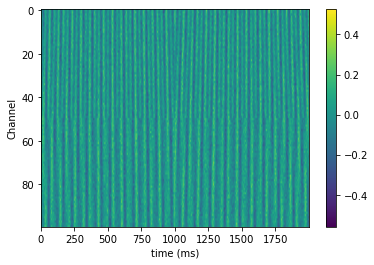

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0.5, 0, 'time (ms)')

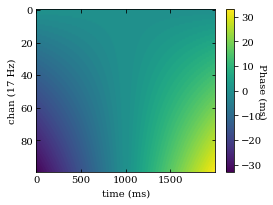

In [4]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(phase_1, aspect='auto')
cbar = fig.colorbar(cax)
cbar.set_label('Phase (ms)', rotation=270)
ax.set_ylabel('chan (17 Hz)')
ax.set_xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

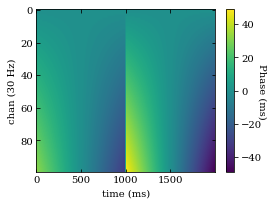

In [5]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(phase_2 , aspect='auto')
cbar = fig.colorbar(cax)
cbar.set_label('Phase (ms)', rotation=270)
ax.set_ylabel('chan (30 Hz)')
ax.set_xlabel('time (ms)')

In [8]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.9, sim_thresh_freq=1, sim_thresh_phi_phase=0.1, opt_win=300)
model.fit_opt(x, t, sr)

Text(0.5, 1.0, 'Similar Solutions')

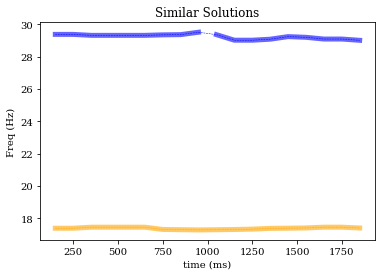

In [9]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.opt_stride/sr, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp, model.sim_thresh_phi_phase)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange']
for i in range(0,len(group_idx),2):
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
            
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [10]:
model.fit_reduction(x, len(t), sr)

Text(0, 0.5, 'Cosine Distance')

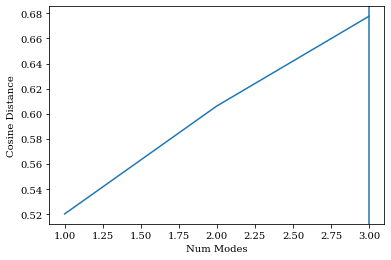

In [12]:
plt.plot(model.num_modes_, model.errors_)
plt.axvline(3)
plt.xlabel('Num Modes')
plt.ylabel('Cosine Distance')

In [13]:
model.fit_f(x, len(t), sr, 3)

Text(0.5, 1.0, 'f(t) vs True f(t)')

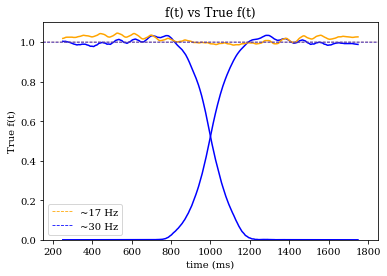

In [18]:
colors = ['blue', 'blue', 'orange', 'green', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,250:-250]):
    plt.plot(np.arange(250,1750), f, color=colors[i])

plt.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label='~17 Hz', linestyle='dashed', linewidth=0.8)
plt.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label='~30 Hz', linestyle='dashed', linewidth=0.8)
plt.legend()
plt.xlim(150,1850)
plt.ylim(0,1.1)
plt.xlabel('time (ms)')
plt.ylabel('True f(t)')
plt.title('f(t) vs True f(t)')
# plt.savefig('recentImage')

In [19]:
freq_hat, phi_hat = model.get_freq_and_phi(len(t), sr)

Text(0.5, 0, 'time (ms)')

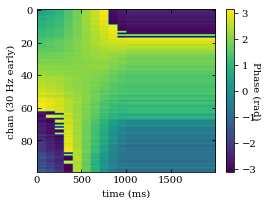

In [27]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(np.angle(phi_hat[0]).T, aspect='auto')
cbar = fig.colorbar(cax)
cbar.set_label('Phase (rad)', rotation=270)
ax.set_ylabel('chan (30 Hz early)')
ax.set_xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

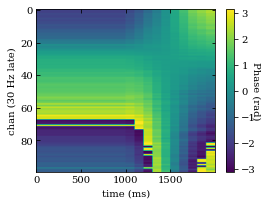

In [28]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(np.angle(phi_hat[1]).T, aspect='auto')
cbar = fig.colorbar(cax)
cbar.set_label('Phase (rad)', rotation=270)
ax.set_ylabel('chan (30 Hz late)')
ax.set_xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

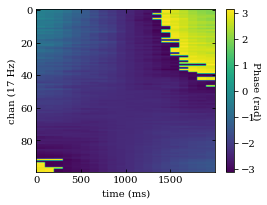

In [29]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(np.angle(phi_hat[2]).T, aspect='auto')
cbar = fig.colorbar(cax)
cbar.set_label('Phase (rad)', rotation=270)
ax.set_ylabel('chan (17 Hz)')
ax.set_xlabel('time (ms)')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

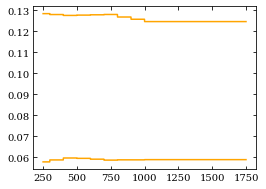

In [23]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

temp = np.mean(np.abs(phi_hat[0][:,:50]), axis=1)
ax.plot(np.arange(250,1750), temp[250:-250], color='orange', label='30 Hz')
temp = np.mean(np.abs(phi_hat[0][:,50:]), axis=1)
ax.plot(np.arange(250,1750), temp[250:-250], color='orange')
ax.plot(np.arange(250,1750), (phi_2 / np.sum(phi_2**2, axis=0)**0.5)[0,250:-250], color='orange', \
        linestyle='dashed')
ax.plot(np.arange(250,1750), (phi_2 / np.sum(phi_2**2, axis=0)**0.5)[-1,250:-250], color='orange', \
        linestyle='dashed')

temp = np.mean(np.abs(phi_hat[1][:,:50]), axis=1)
ax.plot(np.arange(250,1750), temp[250:-250], color='blue', label='17 Hz')
temp = np.mean(np.abs(phi_hat[1][:,50:]), axis=1)
ax.plot(np.arange(250,1750), temp[250:-250], color='blue')
ax.plot(np.arange(250,1750), (phi_1 / np.sum(phi_1**2, axis=0)**0.5)[0,250:-250], color='blue', \
        linestyle='dashed')
ax.plot(np.arange(250,1750), (phi_1 / np.sum(phi_1**2, axis=0)**0.5)[-1,250:-250], color='blue', \
        linestyle='dashed')

ax.legend()

ax.set_xlabel('time (ms)')
ax.set_ylabel('Phi Amp (mean)')
# plt.savefig('figs/phi_drift_all.svg', bbox_inches='tight')

In [30]:
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

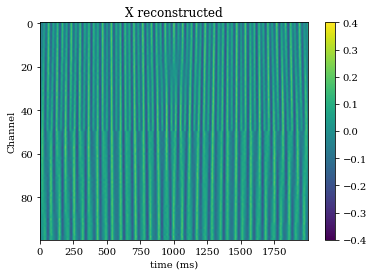

In [31]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

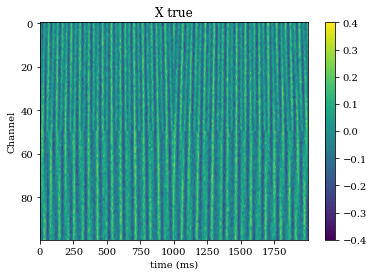

In [32]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')